# MMCloud Implementation and Analysis 🧠

This Jupyter notebook contains the implementation and analysis of the MMCloud algorithm. The notebook is structured to explore the core principles, dynamic clustering mechanisms, and performance evaluation of the algorithm.

In [1]:
# import libraries
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances, calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

# set the style of the plots
plt.style.use("ggplot")
sns.set_theme(palette="pastel")

In [2]:
# columns that we will use
columns = ["load", "speed", "rpm", "tp", "area", "cloud_index", "latitude", "longitude", "mmcloud_time"]

In [3]:
def dunn_index(X, labels):
    """
    Calculate the Dunn index.

    Parameters:
    - X: array-like or matrix, shape (n_samples, n_features)
        The data.
    - labels: array-like, shape (n_samples,)
        Cluster labels for each sample.

    Returns:
    - float
        The value of the Dunn index, or NaN if the computation is invalid.
    """
    distances = pairwise_distances(X)
    max_intracluster_distance = 0
    min_intercluster_distance = float('inf')
    unique_labels = np.unique(labels)

    for label in unique_labels:
        cluster_points = X[labels == label]
        
        if len(cluster_points) == 0:
            continue  # Skip empty clusters
        
        # Calculate the maximum intracluster distance
        intracluster_distances = pairwise_distances(cluster_points)
        current_max_intracluster_distance = np.max(intracluster_distances)
        max_intracluster_distance = max(max_intracluster_distance, current_max_intracluster_distance)

        # Calculate the minimum intercluster distance
        for other_label in unique_labels:
            if label != other_label:
                other_cluster_points = X[labels == other_label]
                if len(other_cluster_points) == 0:
                    continue  # Skip empty clusters
                
                intercluster_distances = pairwise_distances(cluster_points, other_cluster_points)
                current_min_intercluster_distance = np.min(intercluster_distances)
                min_intercluster_distance = min(min_intercluster_distance, current_min_intercluster_distance)

    # Avoid division by zero or invalid cases
    if max_intracluster_distance == 0 or min_intercluster_distance == float('inf'):
        return float('nan')

    return min_intercluster_distance / max_intracluster_distance

## Experiment 1 - Driver 1 - Car 1

In [4]:
# read the data
driver1_car1 = pd.read_csv('./data/exp1_driver1_car1.csv')

# show the first 5 rows 
driver1_car1.head()

,speed,rpm,tp,load,timing,area,acc_x,acc_y,acc_z,ethanol_fuel_level,coolant_temp,intake_manifold_pressure,afr,battery_voltage,fuel_level,mmcloud_time,cloud_index,latitude,longitude
0,15,1485,14,25,24,577.000000,0.06,0.04,-0.02,NaN,94,37,100,1318,100,570,1,-5.843028,-35.197472
1,14,1531,16,24,23,594.890015,-0.09,-0.27,-0.01,NaN,94,40,100,1318,100,477,1,-5.843019,-35.197517
2,15,1618,17,25,27,663.600037,-0.08,-0.24,-0.02,NaN,93,47,100,1315,100,1924,0,-5.843021,-35.197536
3,15,1595,20,31,21,826.849976,-0.01,-0.15,0.01,NaN,93,55,100,1313,100,925,0,-5.843062,-35.197556
4,17,1538,20,37,18,955.260010,-0.17,-0.13,0.02,NaN,92,55,100,1334,100,1926,0,-5.843095,-35.197559


In [5]:
# filter the columns
driver1_car1 = driver1_car1[columns]

In [6]:
# get the statistics of each cloud point
grouped = driver1_car1.groupby('cloud_index')

# get the mean and std of each cloud point
mean = grouped.mean()
std = grouped.std()

# print the mean and std of each cloud point
print(mean)
print(std)

                  load      speed          rpm         tp         area  \
cloud_index                                                              
0            31.588652  31.661939  1442.040189  16.799054   996.014244   
1            53.492754  46.101449  2081.956522  51.246377  3261.730003   
2            67.981651  49.146789  2247.229358  82.798165  6059.725555   

             latitude  longitude  mmcloud_time  
cloud_index                                     
0           -5.837235 -35.204334    668.687943  
1           -5.837737 -35.202357    643.231884  
2           -5.839195 -35.201192    625.275229  
                  load      speed         rpm         tp         area  \
cloud_index                                                             
0            12.302509  19.648611  252.929211   4.263234   319.747120   
1            13.058267  25.114529  294.157693  29.685313   809.952603   
2            13.432948  18.377636  288.394651  15.945381  1309.897266   

             latit

### Scatter plot Analysis

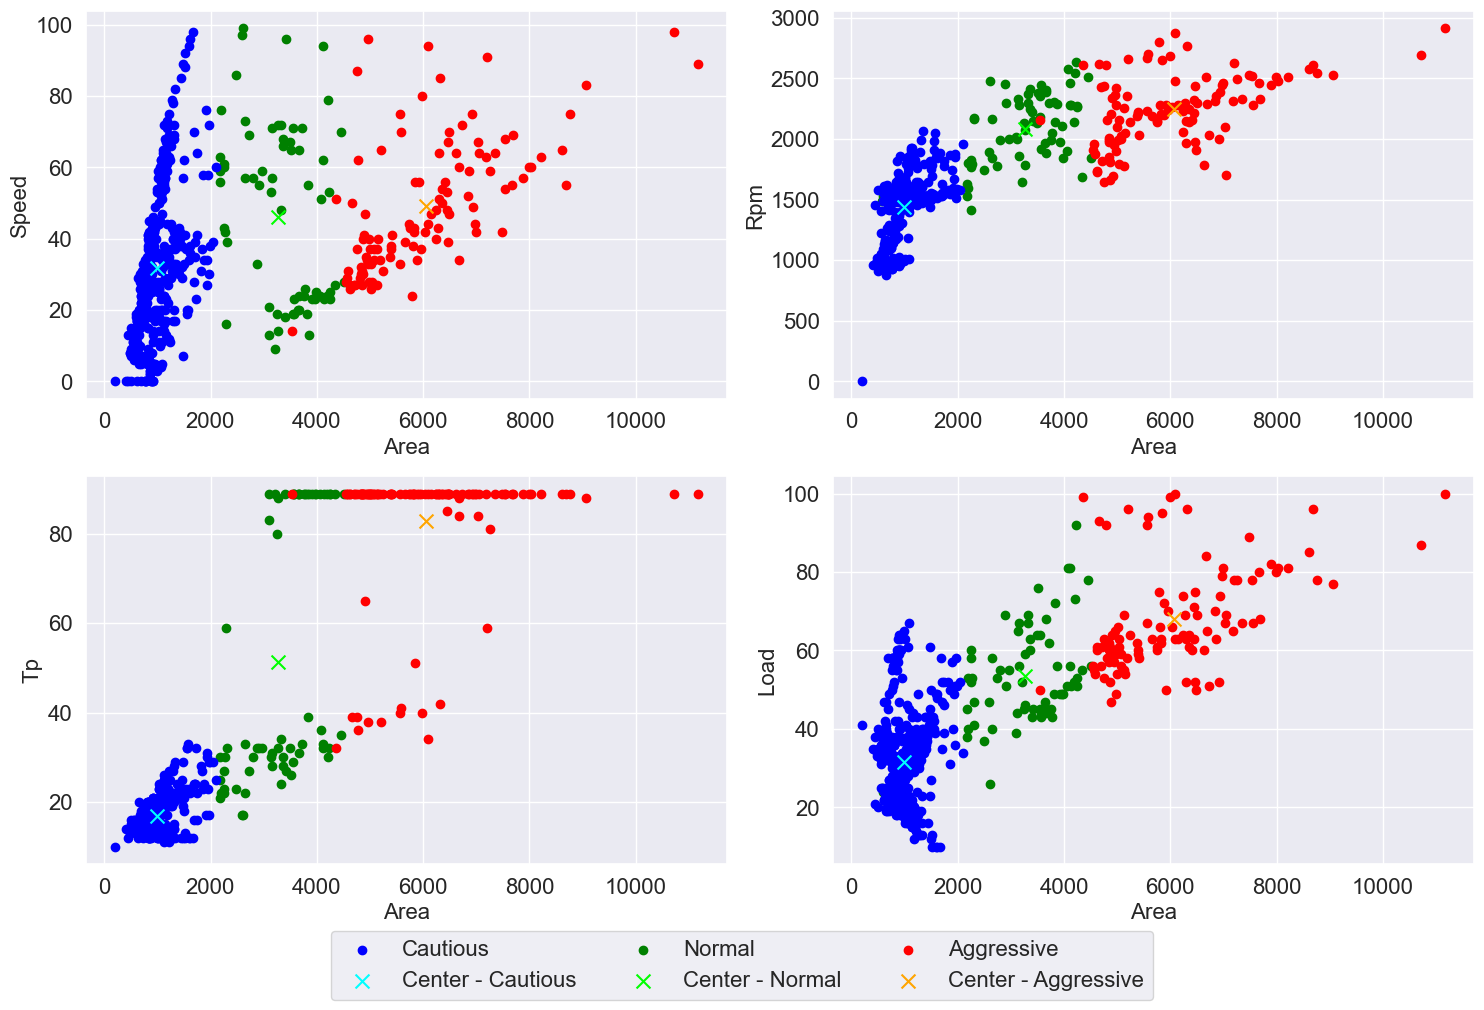

In [22]:
import matplotlib.pyplot as plt

# define the columns that will be used in the plot
columns_names = ['speed', 'rpm', 'tp', 'load']
titles = ['Speed', 'RPM', 'Throttle Position', 'Engine Load']

# define the colors for the points
point_colors = ["blue", "green", "red"]

# define the colors for the center of the clusters
center_colors = ["cyan", "lime", "orange"]

# create the figure and the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# group the data by the cloud index
grouped = driver1_car1.groupby('cloud_index')
sorted_clusters = sorted(grouped, key=lambda x: x[0])  # Garante a ordem 0, 1, 2

# iterate over the columns and the subplots
for idx, (col, ax) in enumerate(zip(columns_names, axes)):
    for i, group in sorted_clusters:
        i = int(i)

        cloud_label = ""
        if i == 0:
            cloud_label = "Cautious"
        elif i == 1:
            cloud_label = "Normal"
        else:
            cloud_label = "Aggressive"

        ax.scatter(
            group['area'], group[col],
            c=point_colors[i], label=cloud_label,
            zorder=2 if i == 0 else 1
        )
        ax.scatter(
            group['area'].mean(), group[col].mean(),
            marker='x', s=100, label=f"Center - {cloud_label}",
            c=center_colors[i], zorder=3
        )
    # ax.set_title(titles[idx], fontsize=16)
    ax.set_xlabel('Area', fontsize=16)
    ax.set_ylabel(col.capitalize(), fontsize=16)
    ax.tick_params(axis='both', labelsize=16)

# coletar handles e labels apenas uma vez
handles, labels = axes[0].get_legend_handles_labels()
order = [0, 1, 2, 3, 4, 5]

# adicionar legenda global centralizada abaixo das figuras
fig.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    loc='lower center', ncol=3, fontsize=16, bbox_to_anchor=(0.5, -0.02)
)

# ajustar o layout
plt.tight_layout(rect=[0, 0.05, 1, 1])  # deixa espaço inferior para a legenda
plt.savefig('./figures/scatter_driver1_car1.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Cluster Quality Analysis

In [9]:
# drop the rows with NaN values
driver1_car1_metrics = driver1_car1[driver1_car1.cloud_index.notna()]

# calculate the metrics for area and load
ss = silhouette_score(driver1_car1_metrics[['area', 'load']], driver1_car1_metrics['cloud_index'])
dbs = davies_bouldin_score(driver1_car1_metrics[['area', 'load']], driver1_car1_metrics['cloud_index'])
ch = calinski_harabasz_score(driver1_car1_metrics[['area', 'load']], driver1_car1_metrics['cloud_index'])
di = dunn_index(driver1_car1_metrics[['area', 'load']], driver1_car1_metrics['cloud_index'])

print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Score: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}")

# calculate the metrics for area and speed
ss = silhouette_score(driver1_car1_metrics[['area', 'speed']], driver1_car1_metrics['cloud_index'])
dbs = davies_bouldin_score(driver1_car1_metrics[['area', 'speed']], driver1_car1_metrics['cloud_index'])
ch = calinski_harabasz_score(driver1_car1_metrics[['area', 'speed']], driver1_car1_metrics['cloud_index'])
di = dunn_index(driver1_car1_metrics[['area', 'speed']], driver1_car1_metrics['cloud_index'])

print("Results for Area and Speed")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}")

# calculate the metrics for area and rpm
ss = silhouette_score(driver1_car1_metrics[['area', 'rpm']], driver1_car1_metrics['cloud_index'])
dbs = davies_bouldin_score(driver1_car1_metrics[['area', 'rpm']], driver1_car1_metrics['cloud_index'])
ch = calinski_harabasz_score(driver1_car1_metrics[['area', 'rpm']], driver1_car1_metrics['cloud_index'])
di = dunn_index(driver1_car1_metrics[['area', 'rpm']], driver1_car1_metrics['cloud_index'])

print("Results for Area and RPM")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}")

# calculate the metrics for area and tp
ss = silhouette_score(driver1_car1_metrics[['area', 'tp']], driver1_car1_metrics['cloud_index'])
dbs = davies_bouldin_score(driver1_car1_metrics[['area', 'tp']], driver1_car1_metrics['cloud_index'])
ch = calinski_harabasz_score(driver1_car1_metrics[['area', 'tp']], driver1_car1_metrics['cloud_index'])
di = dunn_index(driver1_car1_metrics[['area', 'tp']], driver1_car1_metrics['cloud_index'])

print("Results for Area and Throttle Position")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}")

Silhouette Score: 0.7239
Davies-Bouldin Score: 0.5209
Calinski-Harabasz Score: 2533.474
Dunn Index: 0.0006
Results for Area and Speed
Silhouette Score: 0.7236
Davies-Bouldin Score: 0.5217
Calinski-Harabasz Scoret: 2532.0056
Dunn Index: 0.0001
Results for Area and RPM
Silhouette Score: 0.6833
Davies-Bouldin Score: 0.5679
Calinski-Harabasz Scoret: 2263.7708
Dunn Index: 0.0025
Results for Area and Throttle Position
Silhouette Score: 0.7242
Davies-Bouldin Score: 0.5216
Calinski-Harabasz Scoret: 2533.776
Dunn Index: 0.0


/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml

### Time spent in each Cluster Analysis

In [10]:
# add an auxiliary column to identify the cluster changes
driver1_car1['change'] = driver1_car1['cloud_index'].ne(driver1_car1['cloud_index'].shift())

# calculate the duration of each stay in the same cluster
driver1_car1['duration'] = driver1_car1['change'].cumsum()

# group by `duration` and calculate the time in each sequence
cluster_durations = driver1_car1.groupby(['duration', 'cloud_index']).size().reset_index(name='time_in_cluster')

# calculate the total time in each cluster
total_time_per_cluster = cluster_durations.groupby('cloud_index')['time_in_cluster'].sum()

# calculate the average time in each cluster
average_time_per_cluster = cluster_durations.groupby('cloud_index')['time_in_cluster'].mean()

# calculate the general average time before a change
average_time_general = cluster_durations['time_in_cluster'].mean()

# results
print(f"Total time per cluster: ")
print(total_time_per_cluster)

print("\nAverage time per cluster: ")
print(average_time_per_cluster)

print("\nAverage general time before a change:")
print(average_time_general)

Total time per cluster: 
cloud_index
0    423
1     69
2    109
Name: time_in_cluster, dtype: int64

Average time per cluster: 
cloud_index
0    16.920000
1     1.604651
2     4.037037
Name: time_in_cluster, dtype: float64

Average general time before a change:
6.326315789473684


### MMCloud Runtime Execution Analysis

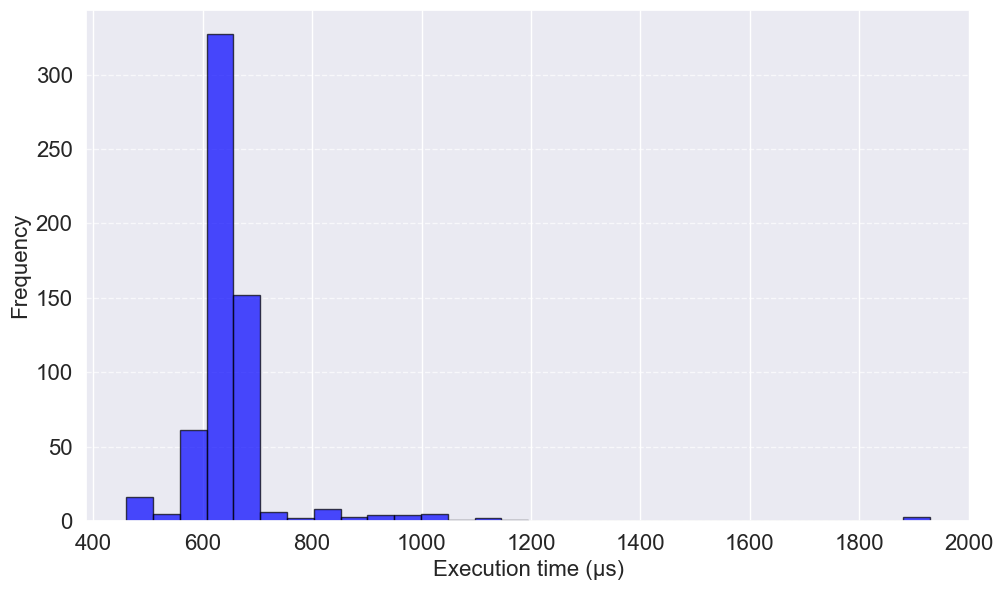

In [27]:
# plot the histogram of the 'mmcloud_time' column
plt.figure(figsize=(10, 6))
plt.hist(driver1_car1['mmcloud_time'], bins=30, color='blue', alpha=0.7, edgecolor='black')

# graph settings
# plt.title('MMCloud Runtime Distribution for Driver 1 - Car 1', fontsize=14)
plt.xlabel('Execution time (µs)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# show the plot
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./figures/runtime_distribution_driver1_car1.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Route Analysis

In [13]:
# drop the rows with NaN values in latitude and longitude columns
driver1_car1.dropna(subset=["latitude", "longitude"], inplace=True)

In [14]:
# create the map
m = folium.Map(location=[driver1_car1.latitude.mean(), driver1_car1.longitude.mean()], zoom_start=15)

# colors for the points
colors = ['blue', 'green', "red"]

for i, row in driver1_car1.iterrows():
    if not np.isnan(row['cloud_index']):
        folium.CircleMarker(
            [row['latitude'], row['longitude']], 
            radius=5, 
            color=colors[int(row['cloud_index'])], 
            fill=True
        ).add_to(m)

# add a legend
legend_html = """
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 120px; height: 100px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 ">&nbsp; <b>Legend</b> <br>
                  &nbsp; Cautious &nbsp; <i class="fa fa-circle" style="color:blue"></i><br>
                  &nbsp; Normal &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
                  &nbsp; Aggressive &nbsp; <i class="fa fa-circle" style="color:red"></i>
      </div>
     """

m.get_root().html.add_child(folium.Element(legend_html))

# save to html
m.save('./maps/driver1_car1.html')

## Experiment 2 - Driver 1 - Car 2

In [16]:
# read the data
driver1_car2 = pd.read_csv('./data/exp1_driver1_car2.csv')

# show the first 5 rows
driver1_car2.head()

,speed,rpm,tp,load,timing,area,acc_x,acc_y,acc_z,ethanol_fuel_level,coolant_temp,intake_manifold_pressure,afr,battery_voltage,fuel_level,mmcloud_time,cloud_index,latitude,longitude
0,0,977,15,15,3,185.775009,-0.01,0.00,0.01,NaN,88,56,100,1459,59.0,878,1,-5.843013,-35.197319
1,0,979,15,15,4,185.925003,-0.03,0.00,-0.01,NaN,88,56,100,1473,59.0,485,1,-5.843037,-35.197304
2,0,980,15,15,2,186.000000,0.02,0.01,-0.01,NaN,88,57,100,1467,59.0,473,1,-5.843068,-35.197285
3,0,981,15,15,1,186.074997,0.04,0.01,0.00,NaN,88,57,100,1479,59.0,501,1,-5.843070,-35.197281
4,0,982,15,15,3,186.149994,0.02,0.00,-0.02,NaN,88,57,100,1470,59.0,492,1,-5.843069,-35.197281


In [17]:
# filter the columns
driver1_car2 = driver1_car2[columns]

In [18]:
driver1_car2

,load,speed,rpm,tp,area,cloud_index,latitude,longitude,mmcloud_time
0,15,0,977,15,185.775009,1,-5.843013,-35.197319,878
1,15,0,979,15,185.925003,1,-5.843037,-35.197304,485
2,15,0,980,15,186.000000,1,-5.843068,-35.197285,473
3,15,0,981,15,186.074997,1,-5.843070,-35.197281,501
4,15,0,982,15,186.149994,1,-5.843069,-35.197281,492
...,...,...,...,...,...,...,...,...,...
640,26,0,1013,18,365.690002,0,-5.843095,-35.197247,647
641,25,0,1008,18,351.000000,0,-5.843095,-35.197247,647
642,18,0,1016,15,226.440002,0,-5.843095,-35.197247,1011
643,13,0,1001,14,156.065002,0,-5.843094,-35.197247,649


In [19]:
# get the statistics of each cloud point
grouped = driver1_car2.groupby('cloud_index')

# get the mean and std of each cloud point
mean = grouped.mean()
std = grouped.std()

# print the mean and std of each cloud point
print(mean)
print(std)

                  load      speed          rpm         tp         area  \
cloud_index                                                              
0            14.726519  26.480663  1390.660221  15.955801   637.645510   
1            31.060345  39.905172  1800.064655  25.711207  1560.425654   
2            52.000000  45.705882  2000.117647  62.745098  4120.686476   

             latitude  longitude  mmcloud_time  
cloud_index                                     
0           -5.838513 -35.203149    714.116022  
1           -5.837360 -35.203894    678.556034  
2           -5.838312 -35.199121    600.215686  
                  load      speed         rpm         tp         area  \
cloud_index                                                             
0             8.042809  16.069307  376.747552   3.773098   288.741576   
1             8.974026  15.746354  327.171203   7.391832   435.293811   
2            10.446052  13.733600  398.352640  23.014642  1542.950008   

             latit

### Scatter plot Analysis

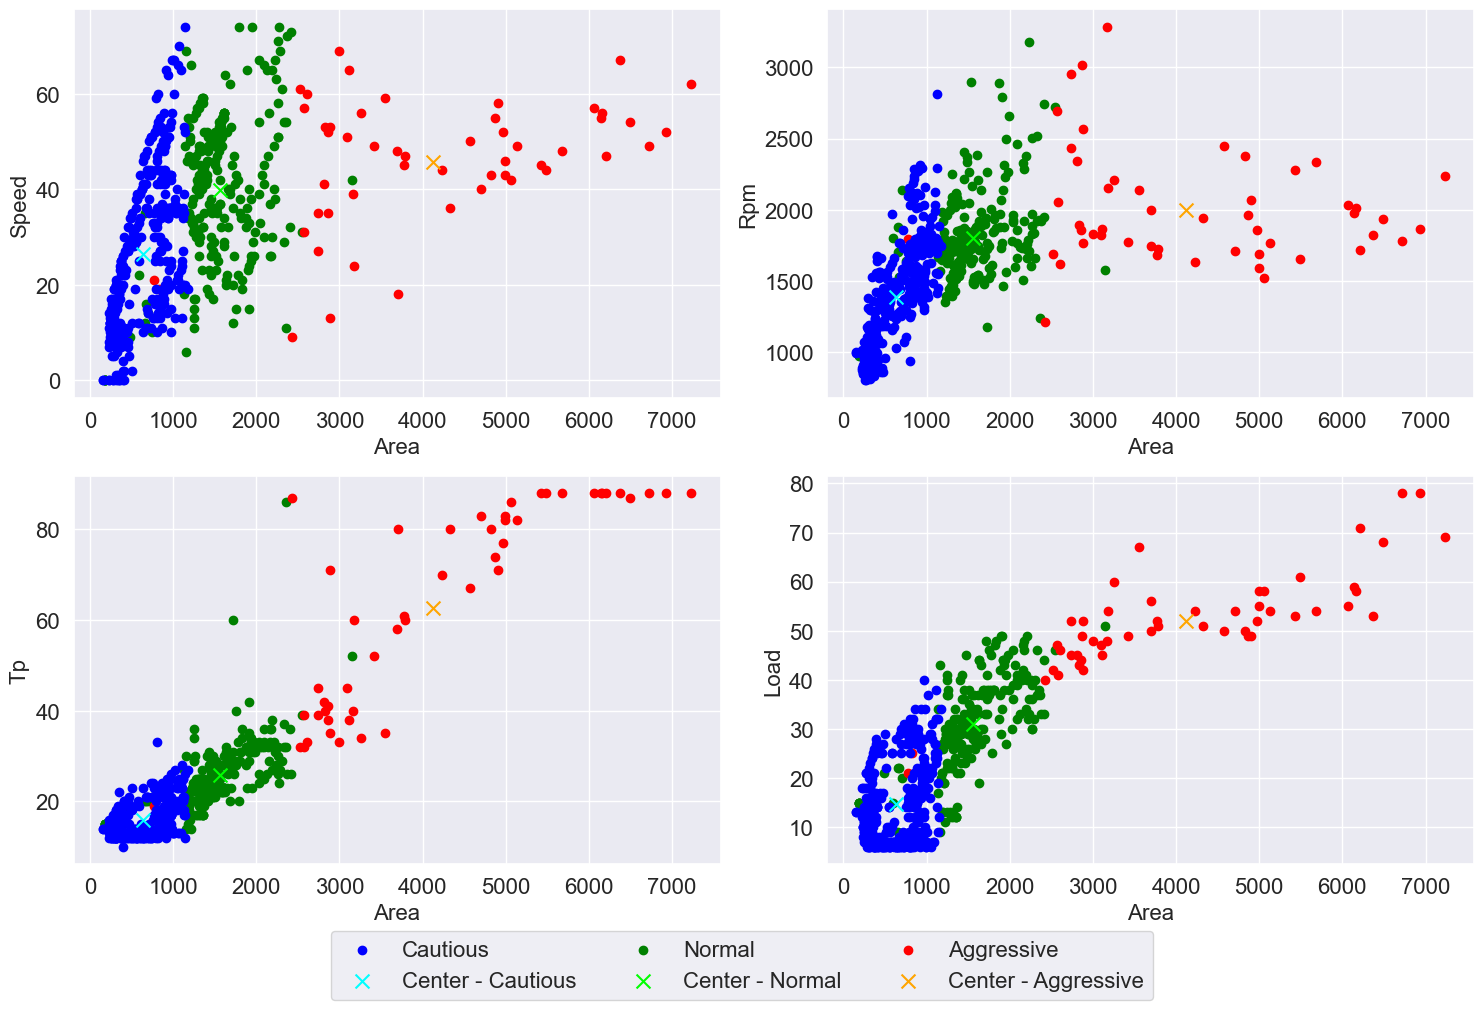

In [21]:
import matplotlib.pyplot as plt

# define the columns that will be used in the plot
columns_names = ['speed', 'rpm', 'tp', 'load']
titles = ['Speed', 'RPM', 'Throttle Position', 'Engine Load']

# define the colors for the points
point_colors = ["blue", "green", "red"]

# define the colors for the center of the clusters
center_colors = ["cyan", "lime", "orange"]

# create the figure and the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# group the data by the cloud index
grouped = driver1_car2.groupby('cloud_index')
sorted_clusters = sorted(grouped, key=lambda x: x[0])  # Garante a ordem 0, 1, 2

# iterate over the columns and the subplots
for idx, (col, ax) in enumerate(zip(columns_names, axes)):
    for i, group in sorted_clusters:
        i = int(i)

        cloud_label = ""
        if i == 0:
            cloud_label = "Cautious"
        elif i == 1:
            cloud_label = "Normal"
        else:
            cloud_label = "Aggressive"

        ax.scatter(
            group['area'], group[col],
            c=point_colors[i], label=cloud_label,
            zorder=2 if i == 0 else 1
        )
        ax.scatter(
            group['area'].mean(), group[col].mean(),
            marker='x', s=100, label=f"Center - {cloud_label}",
            c=center_colors[i], zorder=3
        )
    # ax.set_title(titles[idx], fontsize=16)
    ax.set_xlabel('Area', fontsize=16)
    ax.set_ylabel(col.capitalize(), fontsize=16)
    ax.tick_params(axis='both', labelsize=16)

# coletar handles e labels apenas uma vez
handles, labels = axes[0].get_legend_handles_labels()
order = [0, 1, 2, 3, 4, 5]

# adicionar legenda global centralizada abaixo das figuras
fig.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    loc='lower center', ncol=3, fontsize=16, bbox_to_anchor=(0.5, -0.02)
)

# ajustar o layout
plt.tight_layout(rect=[0, 0.05, 1, 1])  # deixa espaço inferior para a legenda
plt.savefig('./figures/scatter_driver1_car2.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Cluster Quality Metrics

In [23]:
driver1_car2_metrics = driver1_car2[driver1_car2.cloud_index.notna()]
ss = silhouette_score(driver1_car2_metrics[['area', 'load']], driver1_car2_metrics['cloud_index'])
dbs = davies_bouldin_score(driver1_car2_metrics[['area', 'load']], driver1_car2_metrics['cloud_index'])
ch = calinski_harabasz_score(driver1_car2_metrics[['area', 'load']], driver1_car2_metrics['cloud_index'])
di = dunn_index(driver1_car2_metrics[['area', 'load']], driver1_car2_metrics['cloud_index'])

print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Score: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}")

# calculate the metrics for area and speed
ss = silhouette_score(driver1_car2_metrics[['area', 'speed']], driver1_car2_metrics['cloud_index'])
dbs = davies_bouldin_score(driver1_car2_metrics[['area', 'speed']], driver1_car2_metrics['cloud_index'])
ch = calinski_harabasz_score(driver1_car2_metrics[['area', 'speed']], driver1_car2_metrics['cloud_index'])
di = dunn_index(driver1_car2_metrics[['area', 'speed']], driver1_car2_metrics['cloud_index'])

print("Results for Area and Speed")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}")

# calculate the metrics for area and rpm
ss = silhouette_score(driver1_car2_metrics[['area', 'rpm']], driver1_car2_metrics['cloud_index'])
dbs = davies_bouldin_score(driver1_car2_metrics[['area', 'rpm']], driver1_car2_metrics['cloud_index'])
ch = calinski_harabasz_score(driver1_car2_metrics[['area', 'rpm']], driver1_car2_metrics['cloud_index'])
di = dunn_index(driver1_car2_metrics[['area', 'rpm']], driver1_car2_metrics['cloud_index'])

print("Results for Area and RPM")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}")

# calculate the metrics for area and tp
ss = silhouette_score(driver1_car2_metrics[['area', 'tp']], driver1_car2_metrics['cloud_index'])
dbs = davies_bouldin_score(driver1_car2_metrics[['area', 'tp']], driver1_car2_metrics['cloud_index'])
ch = calinski_harabasz_score(driver1_car2_metrics[['area', 'tp']], driver1_car2_metrics['cloud_index'])
di = dunn_index(driver1_car2_metrics[['area', 'tp']], driver1_car2_metrics['cloud_index'])

print("Results for Area and Throttle Position")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}")

Silhouette Score: 0.5288
Davies-Bouldin Score: 0.636
Calinski-Harabasz Score: 962.3337
Dunn Index: 0.0003
Results for Area and Speed
Silhouette Score: 0.528
Davies-Bouldin Score: 0.6366
Calinski-Harabasz Scoret: 961.6932
Dunn Index: 0.0003
Results for Area and RPM
Silhouette Score: 0.408
Davies-Bouldin Score: 0.8044
Calinski-Harabasz Scoret: 709.2032
Dunn Index: 0.0023
Results for Area and Throttle Position
Silhouette Score: 0.529
Davies-Bouldin Score: 0.6359
Calinski-Harabasz Scoret: 962.3788
Dunn Index: 0.0


/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml

### Time spent in each Cluster Analysis

In [24]:
# add an auxiliary column to identify the cluster changes
driver1_car2['change'] = driver1_car2['cloud_index'].ne(driver1_car2['cloud_index'].shift())

# calculate the duration of each stay in the same cluster
driver1_car2['duration'] = driver1_car2['change'].cumsum()

# group by `duration` and calculate the time in each sequence
cluster_durations = driver1_car2.groupby(['duration', 'cloud_index']).size().reset_index(name='time_in_cluster')

# calculate the total time in each cluster
total_time_per_cluster = cluster_durations.groupby('cloud_index')['time_in_cluster'].sum()

# calculate the average time in each cluster
average_time_per_cluster = cluster_durations.groupby('cloud_index')['time_in_cluster'].mean()

# calculate the general average time before a change
average_time_general = cluster_durations['time_in_cluster'].mean()

# results
print("Tempo total por cluster:")
print(total_time_per_cluster)

print("\nTempo médio de permanência por cluster:")
print(average_time_per_cluster)

print("\nTempo médio geral de permanência antes de mudança:")
print(average_time_general)

Tempo total por cluster:
cloud_index
0    362
1    232
2     51
Name: time_in_cluster, dtype: int64

Tempo médio de permanência por cluster:
cloud_index
0    16.454545
1     8.285714
2     7.285714
Name: time_in_cluster, dtype: float64

Tempo médio geral de permanência antes de mudança:
11.31578947368421


### MMCloud Runtime Execution Analysis

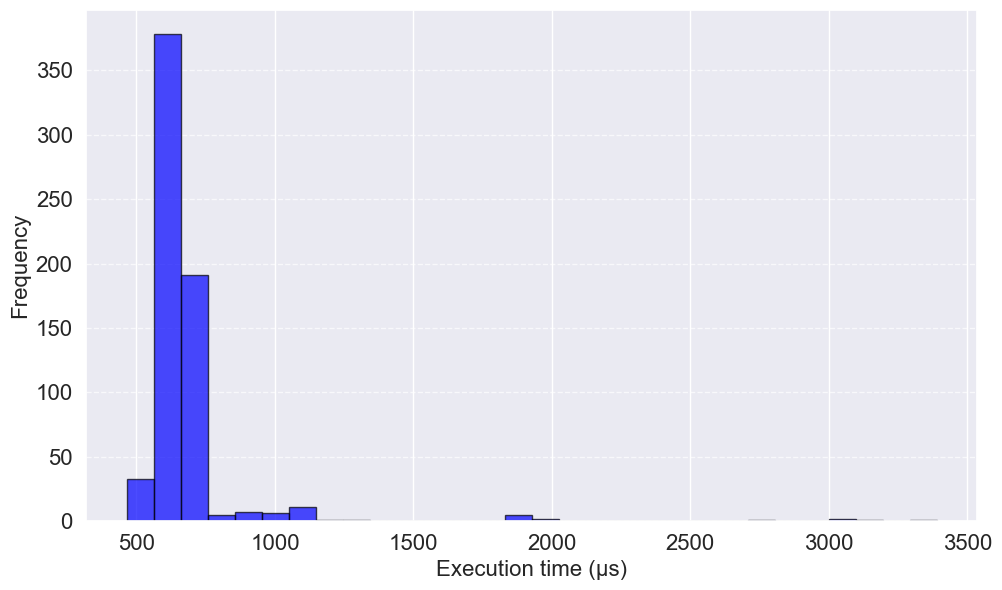

In [26]:
# plot the histogram of the 'mmcloud_time' column
plt.figure(figsize=(10, 6))
plt.hist(driver1_car2['mmcloud_time'], bins=30, color='blue', alpha=0.7, edgecolor='black')

# graph settings
# plt.title('MMCloud Runtime Distribution for Driver 1 - Car 2', fontsize=14)
plt.xlabel('Execution time (µs)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# show the plot
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./figures/runtime_distribution_driver1_car2.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Route Analysis

In [28]:
# drop the rows with NaN values in latitude and longitude columns
driver1_car2.dropna(subset=["latitude", "longitude"], inplace=True)

In [29]:
# Seu código para criar o mapa
m = folium.Map(location=[driver1_car2.latitude.mean(), driver1_car2.longitude.mean()], zoom_start=15)

# Colorir os clusters
colors = ['blue', 'green', "red"]

for i, row in driver1_car2.iterrows():
    if not np.isnan(row['cloud_index']):
        folium.CircleMarker(
            [row['latitude'], row['longitude']], 
            radius=5, 
            color=colors[int(row['cloud_index'])], 
            fill=True
        ).add_to(m)

# Adicionar a legenda
legend_html = """
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 120px; height: 100px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 ">&nbsp; <b>Legend</b> <br>
                  &nbsp; Cautious &nbsp; <i class="fa fa-circle" style="color:blue"></i><br>
                  &nbsp; Normal &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
                  &nbsp; Aggressive &nbsp; <i class="fa fa-circle" style="color:red"></i>
      </div>
     """

m.get_root().html.add_child(folium.Element(legend_html))

# Save to html
m.save('./maps/driver1_car2.html')

## Experiment 3 - Driver 2 - Car 1

In [30]:
# read the data
driver2_car1 = pd.read_csv('./data/exp1_driver2_car1.csv')

# show the first 5 rows
driver2_car1.head()

,speed,rpm,tp,load,timing,area,acc_x,acc_y,acc_z,ethanol_fuel_level,coolant_temp,intake_manifold_pressure,afr,battery_voltage,fuel_level,mmcloud_time,cloud_index,latitude,longitude
0,0,1051,17,52,-15,715.260010,-0.02,-0.04,-0.02,NaN,48,45,100,1291,21,490,1,-5.843028,-35.197472
1,0,1026,16,56,-6,735.280029,0.04,-0.05,0.02,NaN,48,46,100,1302,22,447,1,-5.843019,-35.197517
2,2,976,20,68,-5,1041.599976,0.01,-0.05,0.00,NaN,48,55,100,1297,26,1811,0,-5.843021,-35.197536
3,3,1007,20,69,-7,1082.520020,0.06,-0.08,0.04,NaN,49,56,100,1294,22,461,0,-5.843062,-35.197556
4,6,1030,17,68,-11,1010.100037,0.00,-0.10,-0.01,NaN,49,50,100,1295,21,1814,0,-5.843095,-35.197559


In [31]:
# filter the columns
driver2_car1 = driver2_car1[columns]

In [32]:
# get the statistics of each cloud point
grouped = driver2_car1.groupby('cloud_index')

# get the mean and std of each cloud point
mean = grouped.mean()
std = grouped.std()

# print the mean and std of each cloud point
print(mean)
print(std)

                   load      speed          rpm         tp          area  \
cloud_index                                                                
0             32.473198  30.097967  1444.750462  16.898336    994.521394   
1             60.061069  40.175573  2014.381679  82.633588   5140.615560   
2            100.000000  71.000000  5001.000000  89.000000  11862.410156   

             latitude  longitude  mmcloud_time  
cloud_index                                     
0           -5.838000 -35.203881    582.711645  
1           -5.837857 -35.202734    552.832061  
2           -5.834500 -35.200565    457.500000  
                  load      speed         rpm         tp         area  \
cloud_index                                                             
0            12.756615  18.213437  292.443959   4.981709   351.023588   
1            14.520413  16.297938  584.546063  17.602974  1467.675579   
2             0.000000  18.384776  499.217388   0.000000   851.003011   

        

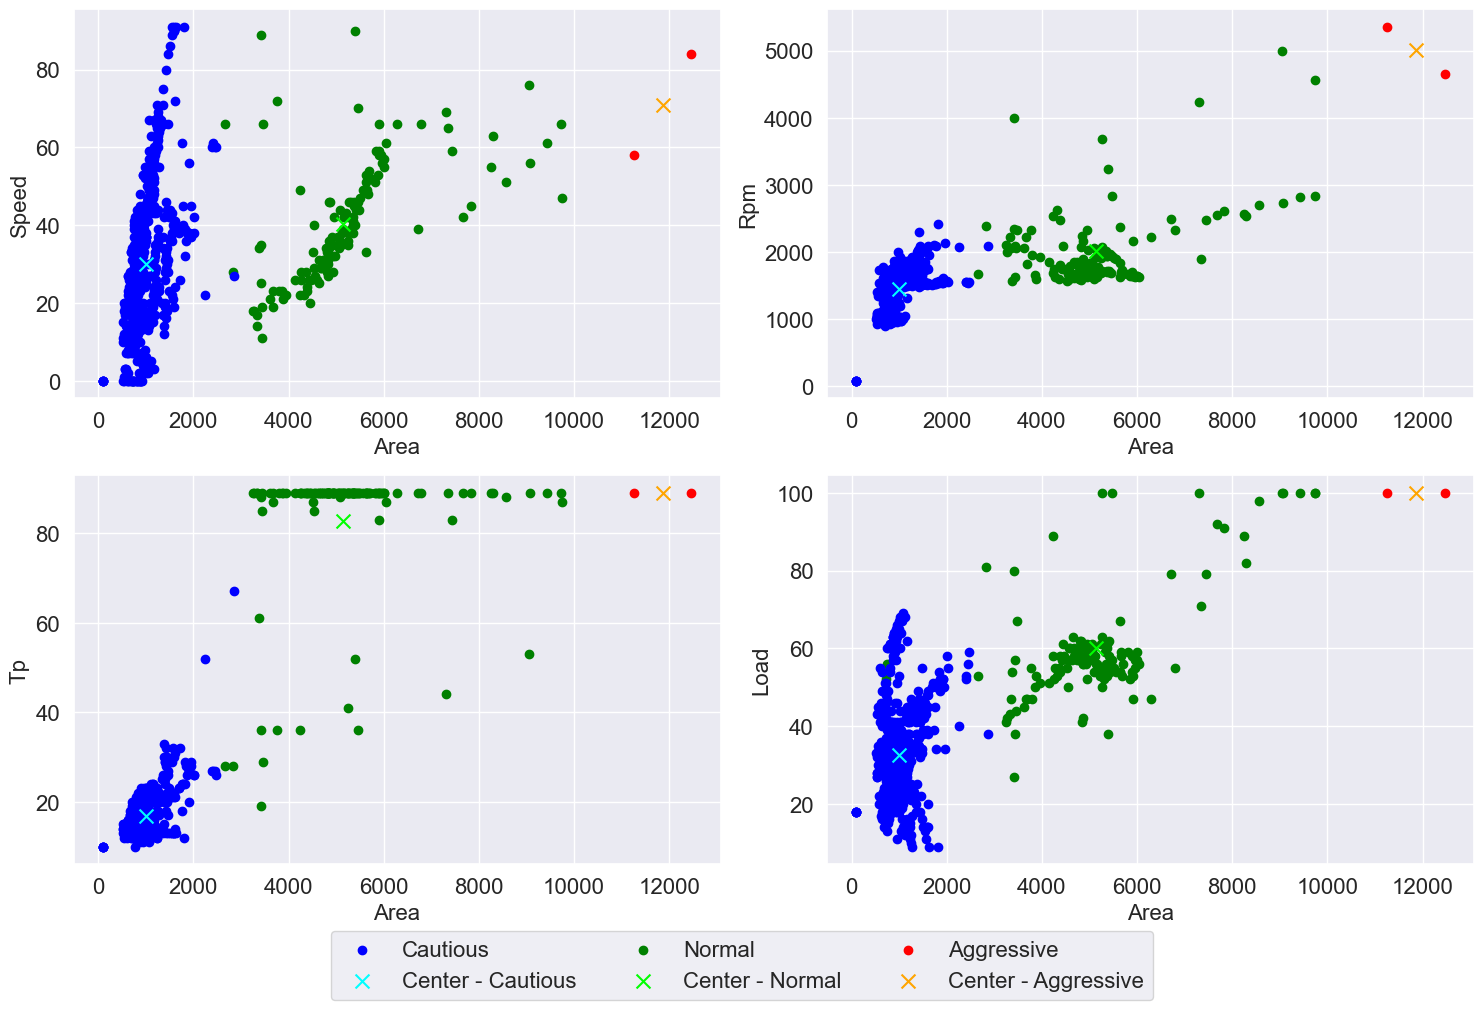

In [33]:
import matplotlib.pyplot as plt

# define the columns that will be used in the plot
columns_names = ['speed', 'rpm', 'tp', 'load']
titles = ['Speed', 'RPM', 'Throttle Position', 'Engine Load']

# define the colors for the points
point_colors = ["blue", "green", "red"]

# define the colors for the center of the clusters
center_colors = ["cyan", "lime", "orange"]

# create the figure and the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# group the data by the cloud index
grouped = driver2_car1.groupby('cloud_index')
sorted_clusters = sorted(grouped, key=lambda x: x[0])  # Garante a ordem 0, 1, 2

# iterate over the columns and the subplots
for idx, (col, ax) in enumerate(zip(columns_names, axes)):
    for i, group in sorted_clusters:
        i = int(i)

        cloud_label = ""
        if i == 0:
            cloud_label = "Cautious"
        elif i == 1:
            cloud_label = "Normal"
        else:
            cloud_label = "Aggressive"

        ax.scatter(
            group['area'], group[col],
            c=point_colors[i], label=cloud_label,
            zorder=2 if i == 0 else 1
        )
        ax.scatter(
            group['area'].mean(), group[col].mean(),
            marker='x', s=100, label=f"Center - {cloud_label}",
            c=center_colors[i], zorder=3
        )
    # ax.set_title(titles[idx], fontsize=16)
    ax.set_xlabel('Area', fontsize=16)
    ax.set_ylabel(col.capitalize(), fontsize=16)
    ax.tick_params(axis='both', labelsize=16)

# coletar handles e labels apenas uma vez
handles, labels = axes[0].get_legend_handles_labels()
order = [0, 1, 2, 3, 4, 5]

# adicionar legenda global centralizada abaixo das figuras
fig.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    loc='lower center', ncol=3, fontsize=16, bbox_to_anchor=(0.5, -0.02)
)

# ajustar o layout
plt.tight_layout(rect=[0, 0.05, 1, 1])  # deixa espaço inferior para a legenda
plt.savefig('./figures/scatter_driver2_car1.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
driver2_car1_metrics = driver2_car1[driver2_car1.cloud_index.notna()]

# calculate the metrics for area and load
ss = silhouette_score(driver2_car1_metrics[['area', 'load']], driver2_car1_metrics['cloud_index'])
dbs = davies_bouldin_score(driver2_car1_metrics[['area', 'load']], driver2_car1_metrics['cloud_index'])
ch = calinski_harabasz_score(driver2_car1_metrics[['area', 'load']], driver2_car1_metrics['cloud_index'])
di = dunn_index(driver2_car1_metrics[['area', 'load']], driver2_car1_metrics['cloud_index'])

print("Results for Area and Load")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}\n")

# calculate the metrics for area and speed
ss = silhouette_score(driver2_car1_metrics[['area', 'speed']], driver2_car1_metrics['cloud_index'])
dbs = davies_bouldin_score(driver2_car1_metrics[['area', 'speed']], driver2_car1_metrics['cloud_index'])
ch = calinski_harabasz_score(driver2_car1_metrics[['area', 'speed']], driver2_car1_metrics['cloud_index'])
di = dunn_index(driver2_car1_metrics[['area', 'speed']], driver2_car1_metrics['cloud_index'])

print("Results for Area and Speed")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}\n")

# calculate the metrics for area and rpm
ss = silhouette_score(driver2_car1_metrics[['area', 'rpm']], driver2_car1_metrics['cloud_index'])
dbs = davies_bouldin_score(driver2_car1_metrics[['area', 'rpm']], driver2_car1_metrics['cloud_index'])
ch = calinski_harabasz_score(driver2_car1_metrics[['area', 'rpm']], driver2_car1_metrics['cloud_index'])
di = dunn_index(driver2_car1_metrics[['area', 'rpm']], driver2_car1_metrics['cloud_index'])

print("Results for Area and RPM")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}\n")

# calculate the metrics for area and tp
ss = silhouette_score(driver2_car1_metrics[['area', 'tp']], driver2_car1_metrics['cloud_index'])
dbs = davies_bouldin_score(driver2_car1_metrics[['area', 'tp']], driver2_car1_metrics['cloud_index'])
ch = calinski_harabasz_score(driver2_car1_metrics[['area', 'tp']], driver2_car1_metrics['cloud_index'])
di = dunn_index(driver2_car1_metrics[['area', 'tp']], driver2_car1_metrics['cloud_index'])

print("Results for Area and Throttle Position")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}")

Results for Area and Load
Silhouette Score: 0.8381
Davies-Bouldin Score: 0.2799
Calinski-Harabasz Scoret: 1945.7452
Dunn Index: 0.0005

Results for Area and Speed
Silhouette Score: 0.838
Davies-Bouldin Score: 0.2799
Calinski-Harabasz Scoret: 1945.1208
Dunn Index: 0.0002

Results for Area and RPM
Silhouette Score: 0.8066
Davies-Bouldin Score: 0.3185
Calinski-Harabasz Scoret: 1587.0529
Dunn Index: 0.0007

Results for Area and Throttle Position
Silhouette Score: 0.8383
Davies-Bouldin Score: 0.2797
Calinski-Harabasz Scoret: 1946.4522
Dunn Index: 0.0001


/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml

In [35]:
# Adiciona uma coluna auxiliar para identificar as mudanças de cluster
driver2_car1['change'] = driver2_car1['cloud_index'].ne(driver2_car1['cloud_index'].shift())

# Calcula a duração de cada permanência no mesmo cluster
driver2_car1['duration'] = driver2_car1['change'].cumsum()

# Agrupa por `duration` e calcula o tempo em cada sequência
cluster_durations = driver2_car1.groupby(['duration', 'cloud_index']).size().reset_index(name='time_in_cluster')

# Calcula o tempo total em cada cluster
total_time_per_cluster = cluster_durations.groupby('cloud_index')['time_in_cluster'].sum()

# Calcula o tempo médio de permanência por cluster
average_time_per_cluster = cluster_durations.groupby('cloud_index')['time_in_cluster'].mean()

# Calcula o tempo médio geral de permanência antes de uma mudança
average_time_general = cluster_durations['time_in_cluster'].mean()

# Resultados
print("Tempo total por cluster:")
print(total_time_per_cluster)

print("\nTempo médio de permanência por cluster:")
print(average_time_per_cluster)

print("\nTempo médio geral de permanência antes de mudança:")
print(average_time_general)

Tempo total por cluster:
cloud_index
0    541
1    131
2      2
Name: time_in_cluster, dtype: int64

Tempo médio de permanência por cluster:
cloud_index
0    28.473684
1     6.238095
2     1.000000
Name: time_in_cluster, dtype: float64

Tempo médio geral de permanência antes de mudança:
16.047619047619047


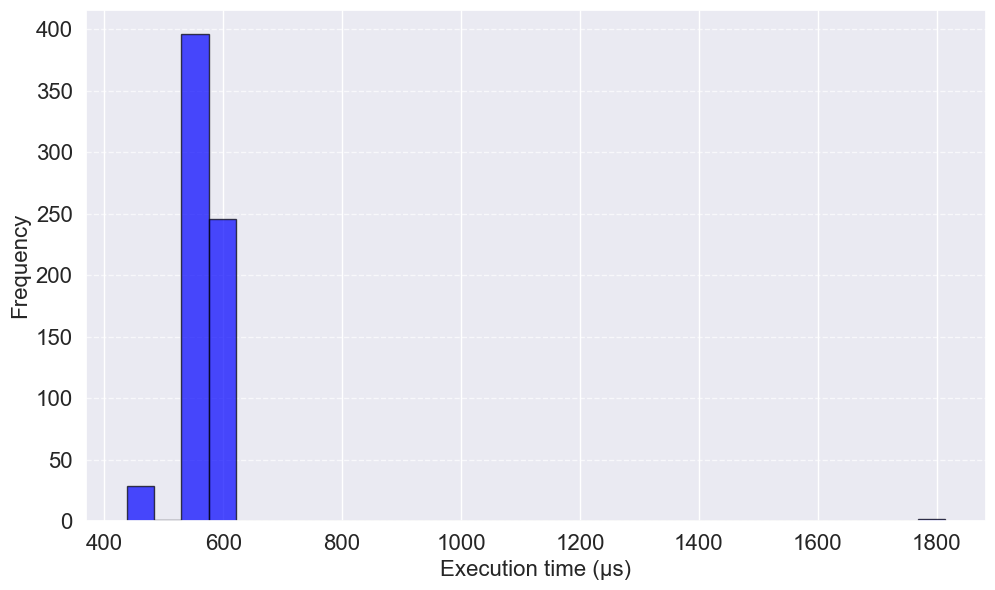

In [36]:
# Plotar o histograma da coluna 'mmcloud_time'
plt.figure(figsize=(10, 6))
plt.hist(driver2_car1['mmcloud_time'], bins=30, color='blue', alpha=0.7, edgecolor='black')

# Configurações do gráfico
# plt.title('MMCloud Runtime Distribution for Driver 2 - Car 2', fontsize=14)
plt.xlabel('Execution time (µs)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar o gráfico
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./figures/runtime_distribution_driver2_car1.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
# create the map
m = folium.Map(location=[driver2_car1.latitude.mean(), driver2_car1.longitude.mean()], zoom_start=15)

# colors for the points
colors = ['blue', 'green', "red"]

for i, row in driver2_car1.iterrows():
    if not np.isnan(row['cloud_index']):
        folium.CircleMarker(
            [row['latitude'], row['longitude']], 
            radius=5, 
            color=colors[int(row['cloud_index'])], 
            fill=True
        ).add_to(m)

# add a legend
legend_html = """
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 120px; height: 100px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 ">&nbsp; <b>Legend</b> <br>
                  &nbsp; Cautious &nbsp; <i class="fa fa-circle" style="color:blue"></i><br>
                  &nbsp; Normal &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
                  &nbsp; Aggressive &nbsp; <i class="fa fa-circle" style="color:red"></i>
      </div>
     """

m.get_root().html.add_child(folium.Element(legend_html))

# Save to html
m.save('./maps/driver2_car1.html')

## Experiment 4 - Driver 2 - Car 2

In [38]:
# read the data
driver2_car2 = pd.read_csv('./data/exp1_driver2_car2.csv')

# show the first 5 rows
driver2_car2.head()

,speed,rpm,tp,load,timing,area,acc_x,acc_y,acc_z,ethanol_fuel_level,coolant_temp,intake_manifold_pressure,afr,battery_voltage,fuel_level,mmcloud_time,cloud_index,latitude,longitude
0,0,983,14,14,3.0,166.809998,0.03,0.02,-0.02,NaN,88.0,54.0,100.0,1465.0,61.0,516,1.0,-5.843028,-35.197472
1,0,982,14,14,3.0,166.739990,-0.01,0.01,0.00,NaN,88.0,54.0,100.0,1459.0,61.0,504,1.0,-5.843019,-35.197517
2,0,977,18,16,-20.0,222.160004,-0.02,0.01,-0.05,NaN,88.0,77.0,100.0,1481.0,61.0,2242,0.0,-5.843021,-35.197536
3,1,926,18,23,-16.0,327.119995,0.00,0.00,-0.14,NaN,88.0,87.0,100.0,1473.0,61.0,577,0.0,-5.843062,-35.197556
4,6,938,18,27,-24.0,451.770020,-0.01,-0.01,-0.12,NaN,88.0,83.0,100.0,1475.0,61.0,2001,0.0,-5.843095,-35.197559


In [39]:
# filter the columns
driver2_car2 = driver2_car2[columns]

In [40]:
# get the statistics of each cloud point
grouped = driver2_car2.groupby('cloud_index')

# get the mean and std of each cloud point
mean = grouped.mean()
std = grouped.std()

# print the mean and std of each cloud point
print(mean)
print(std)


                  load      speed          rpm         tp         area  \
cloud_index                                                              
0.0          10.253846  23.392308  1238.300000  13.884615   447.121652   
1.0          18.385845  35.321918  1661.013699  18.294521   961.136756   
2.0          64.519231  53.173077  2195.192308  74.961538  5799.054974   

             latitude  longitude  mmcloud_time  
cloud_index                                     
0.0         -5.839454 -35.200894    698.307692  
1.0         -5.837589 -35.203999    689.244292  
2.0         -5.839065 -35.201383    598.865385  
                  load      speed         rpm         tp         area  \
cloud_index                                                             
0.0           6.107958  12.425590  263.411743   2.400370   143.724251   
1.0          10.286713  14.722110  331.658988   5.201876   391.249581   
2.0          17.928497  16.042494  409.345486  20.377767  1934.129135   

             latit

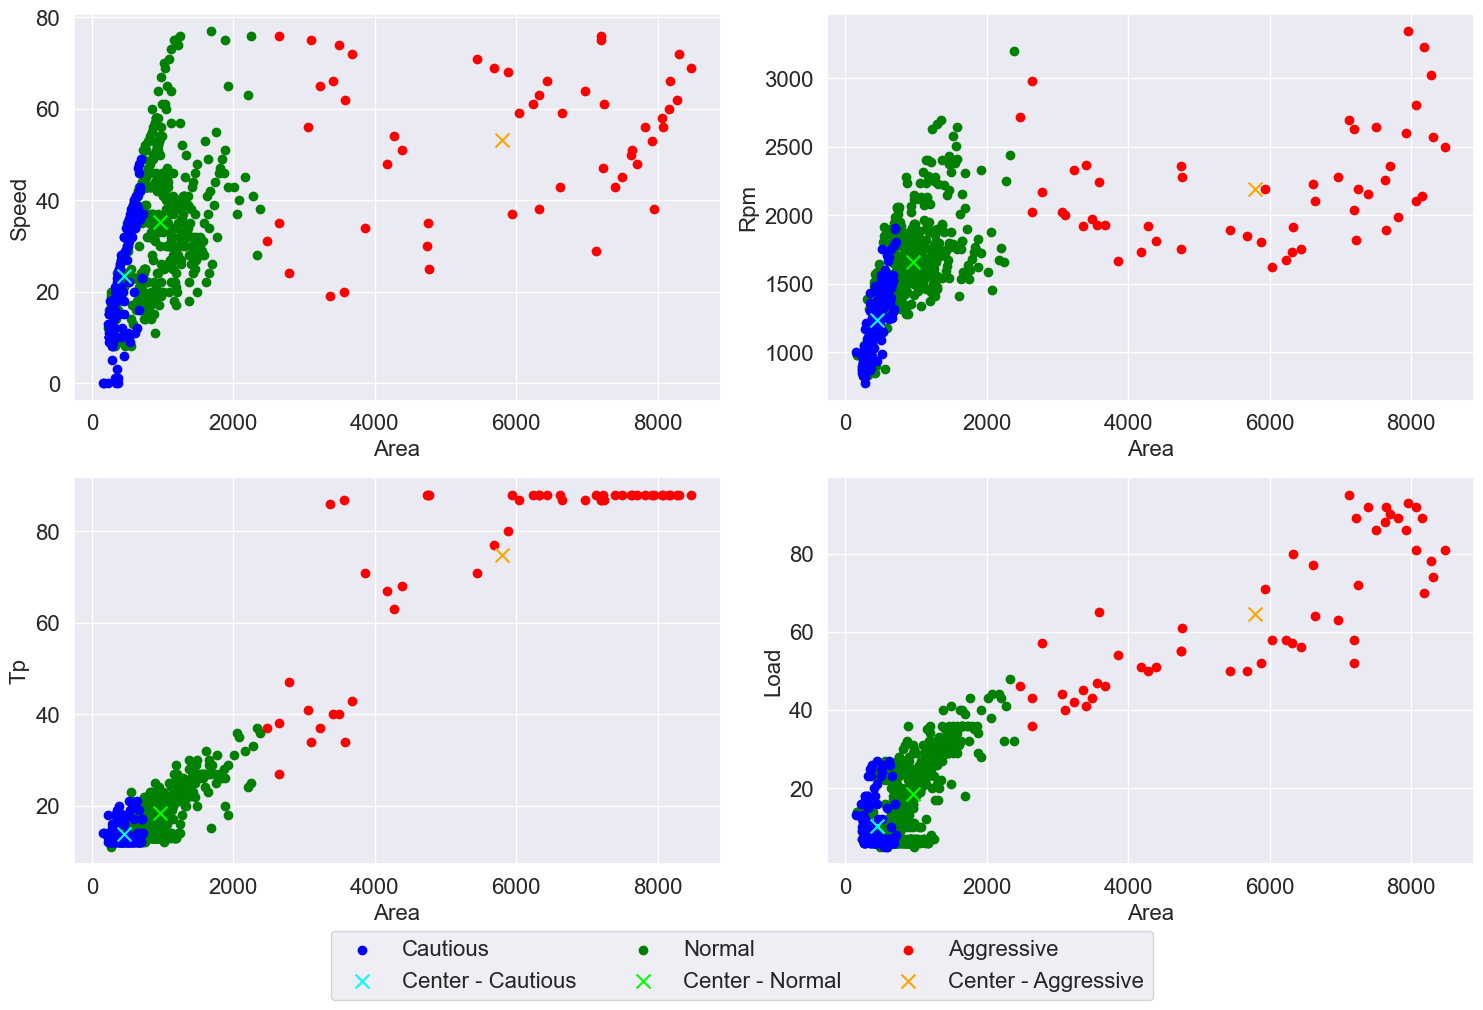

In [41]:
import matplotlib.pyplot as plt

# define the columns that will be used in the plot
columns_names = ['speed', 'rpm', 'tp', 'load']
titles = ['Speed', 'RPM', 'Throttle Position', 'Engine Load']

# define the colors for the points
point_colors = ["blue", "green", "red"]

# define the colors for the center of the clusters
center_colors = ["cyan", "lime", "orange"]

# create the figure and the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# group the data by the cloud index
grouped = driver2_car2.groupby('cloud_index')
sorted_clusters = sorted(grouped, key=lambda x: x[0])  # Garante a ordem 0, 1, 2

# iterate over the columns and the subplots
for idx, (col, ax) in enumerate(zip(columns_names, axes)):
    for i, group in sorted_clusters:
        i = int(i)

        cloud_label = ""
        if i == 0:
            cloud_label = "Cautious"
        elif i == 1:
            cloud_label = "Normal"
        else:
            cloud_label = "Aggressive"

        ax.scatter(
            group['area'], group[col],
            c=point_colors[i], label=cloud_label,
            zorder=2 if i == 0 else 1
        )
        ax.scatter(
            group['area'].mean(), group[col].mean(),
            marker='x', s=100, label=f"Center - {cloud_label}",
            c=center_colors[i], zorder=3
        )
    # ax.set_title(titles[idx], fontsize=16)
    ax.set_xlabel('Area', fontsize=16)
    ax.set_ylabel(col.capitalize(), fontsize=16)
    ax.tick_params(axis='both', labelsize=16)

# coletar handles e labels apenas uma vez
handles, labels = axes[0].get_legend_handles_labels()
order = [0, 1, 2, 3, 4, 5]

# adicionar legenda global centralizada abaixo das figuras
fig.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    loc='lower center', ncol=3, fontsize=16, bbox_to_anchor=(0.5, -0.02)
)

# ajustar o layout
plt.tight_layout(rect=[0, 0.05, 1, 1])  # deixa espaço inferior para a legenda
plt.savefig('./figures/scatter_driver2_car2.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
driver2_car2_metrics = driver2_car2[driver2_car2.cloud_index.notna()]

# calculate the metrics for area and load
ss = silhouette_score(driver2_car2_metrics[['area', 'load']], driver2_car2_metrics['cloud_index'])
dbs = davies_bouldin_score(driver2_car2_metrics[['area', 'load']], driver2_car2_metrics['cloud_index'])
ch = calinski_harabasz_score(driver2_car2_metrics[['area', 'load']], driver2_car2_metrics['cloud_index'])
di = dunn_index(driver2_car2_metrics[['area', 'load']], driver2_car2_metrics['cloud_index'])

print("Results for Area and Load")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}\n")

# calculate the metrics for area and speed
ss = silhouette_score(driver2_car2_metrics[['area', 'speed']], driver2_car2_metrics['cloud_index'])
dbs = davies_bouldin_score(driver2_car2_metrics[['area', 'speed']], driver2_car2_metrics['cloud_index'])
ch = calinski_harabasz_score(driver2_car2_metrics[['area', 'speed']], driver2_car2_metrics['cloud_index'])
di = dunn_index(driver2_car2_metrics[['area', 'speed']], driver2_car2_metrics['cloud_index'])

print("Results for Area and Speed")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}\n")

# calculate the metrics for area and rpm
ss = silhouette_score(driver2_car2_metrics[['area', 'rpm']], driver2_car2_metrics['cloud_index'])
dbs = davies_bouldin_score(driver2_car2_metrics[['area', 'rpm']], driver2_car2_metrics['cloud_index'])
ch = calinski_harabasz_score(driver2_car2_metrics[['area', 'rpm']], driver2_car2_metrics['cloud_index'])
di = dunn_index(driver2_car2_metrics[['area', 'rpm']], driver2_car2_metrics['cloud_index'])

print("Results for Area and RPM")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}\n")

# calculate the metrics for area and tp
ss = silhouette_score(driver2_car2_metrics[['area', 'tp']], driver2_car2_metrics['cloud_index'])
dbs = davies_bouldin_score(driver2_car2_metrics[['area', 'tp']], driver2_car2_metrics['cloud_index'])
ch = calinski_harabasz_score(driver2_car2_metrics[['area', 'tp']], driver2_car2_metrics['cloud_index'])
di = dunn_index(driver2_car2_metrics[['area', 'tp']], driver2_car2_metrics['cloud_index'])

print("Results for Area and Throttle Position")
print(f"Silhouette Score: {round(ss, 4)}")
print(f"Davies-Bouldin Score: {round(dbs, 4)}")
print(f"Calinski-Harabasz Scoret: {round(ch, 4)}")
print(f"Dunn Index: {round(di, 4)}")

Results for Area and Load
Silhouette Score: 0.2589
Davies-Bouldin Score: 0.6823
Calinski-Harabasz Scoret: 1417.4516
Dunn Index: 0.0

Results for Area and Speed
Silhouette Score: 0.2582
Davies-Bouldin Score: 0.6837
Calinski-Harabasz Scoret: 1417.0264
Dunn Index: 0.0

Results for Area and RPM
Silhouette Score: 0.2626
Davies-Bouldin Score: 0.8235
Calinski-Harabasz Scoret: 1167.3814
Dunn Index: 0.0002

Results for Area and Throttle Position
Silhouette Score: 0.2592
Davies-Bouldin Score: 0.6814
Calinski-Harabasz Scoret: 1417.6872
Dunn Index: 0.0


/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/morsinaldo/miniconda3/envs/ml

In [43]:
# Adiciona uma coluna auxiliar para identificar as mudanças de cluster
driver2_car2['change'] = driver2_car2['cloud_index'].ne(driver2_car2['cloud_index'].shift())

# Calcula a duração de cada permanência no mesmo cluster
driver2_car2['duration'] = driver2_car2['change'].cumsum()

# Agrupa por `duration` e calcula o tempo em cada sequência
cluster_durations = driver2_car2.groupby(['duration', 'cloud_index']).size().reset_index(name='time_in_cluster')

# Calcula o tempo total em cada cluster
total_time_per_cluster = cluster_durations.groupby('cloud_index')['time_in_cluster'].sum()

# Calcula o tempo médio de permanência por cluster
average_time_per_cluster = cluster_durations.groupby('cloud_index')['time_in_cluster'].mean()

# Calcula o tempo médio geral de permanência antes de uma mudança
average_time_general = cluster_durations['time_in_cluster'].mean()

# Resultados
print("Tempo total por cluster:")
print(total_time_per_cluster)

print("\nTempo médio de permanência por cluster:")
print(average_time_per_cluster)

print("\nTempo médio geral de permanência antes de mudança:")
print(average_time_general)

Tempo total por cluster:
cloud_index
0.0    130
1.0    438
2.0     52
Name: time_in_cluster, dtype: int64

Tempo médio de permanência por cluster:
cloud_index
0.0     7.222222
1.0    18.250000
2.0     8.666667
Name: time_in_cluster, dtype: float64

Tempo médio geral de permanência antes de mudança:
12.916666666666666


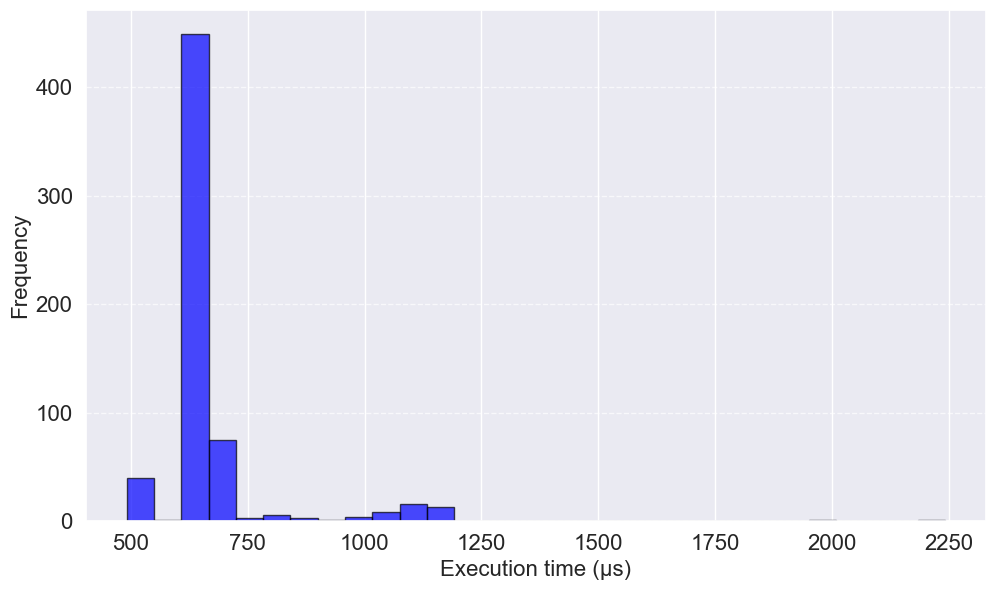

In [44]:
# Plotar o histograma da coluna 'mmcloud_time'
plt.figure(figsize=(10, 6))
plt.hist(driver2_car2['mmcloud_time'], bins=30, color='blue', alpha=0.7, edgecolor='black')

# Configurações do gráfico
# plt.title('MMCloud Runtime Distribution for Driver 2 - Car 2', fontsize=14)
plt.xlabel('Execution time (µs)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar o gráfico
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./figures/runtime_distribution_driver2_car2.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
driver2_car2 = driver2_car2.dropna(subset=['latitude', 'longitude'])

In [46]:
# create the map
m = folium.Map(location=[driver2_car2.latitude.mean(), driver2_car2.longitude.mean()], zoom_start=15)

# colors for the points
colors = ['blue', 'green', "red"]

for i, row in driver2_car2.iterrows():
    if not np.isnan(row['cloud_index']):
        folium.CircleMarker(
            [row['latitude'], row['longitude']], 
            radius=5, 
            color=colors[int(row['cloud_index'])], 
            fill=True
        ).add_to(m)

# add a legend
legend_html = """
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 120px; height: 100px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 ">&nbsp; <b>Legend</b> <br>
                  &nbsp; Cautious &nbsp; <i class="fa fa-circle" style="color:blue"></i><br>
                  &nbsp; Normal &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
                  &nbsp; Aggressive &nbsp; <i class="fa fa-circle" style="color:red"></i>
      </div>
     """

m.get_root().html.add_child(folium.Element(legend_html))

# Save to html
m.save('./maps/driver2_car2.html')